In [2]:
# Dependencies
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')

import numpy as np
import pandas as pd
import datetime as dt
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [3]:
# Using sqlite to read file

engine = create_engine("sqlite:///Resources/hawaii.sqlite")
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [4]:
# References to each table in the database
Measurement = Base.classes.measurement
Station = Base.classes.station

In [5]:
# Create our session (link) from Python to the DB and create a connection
connection = engine.connect()
session = Session(engine)

In [6]:
# Query to return date and prcp values for on the last 12 months of data
# The last 12 months in the data set would be August 24, 2016 - August 23, 2017
date = dt.datetime(2016,8,23)
last_yr = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > date)
last_yr_df = pd.DataFrame(last_yr)

# Drop null values for prcp
last_yr_df_clean = last_yr_df.dropna()
last_yr_df_clean = last_yr_df_clean.set_index('date')
last_yr_df_clean.sort_values('date').head()

,prcp
date,
2016-08-24,0.08
2016-08-24,1.22
2016-08-24,2.28
2016-08-24,1.45
2016-08-24,2.15


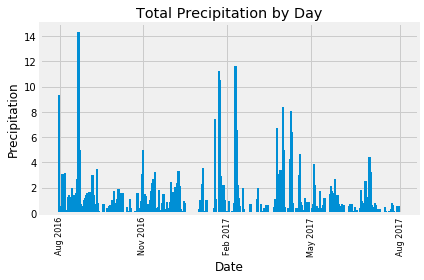

In [7]:
# Group by Dates
prcp_by_date = last_yr_df_clean.groupby('date')
y_axis_prcp = prcp_by_date['prcp'].sum()
x_axis_prcp = last_yr_df_clean.index.unique()

plt.bar(x_axis_prcp,y_axis_prcp,width=2.5)
plt.title('Total Precipitation by Day')
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.xticks(labels=['Aug 2016','Nov 2016','Feb 2017','May 2017', 'Aug 2017'],ticks=[1,90,180,270,365], rotation=90, fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.savefig('Total Precipitation by Day.png')
plt.show()

In [8]:
# Basic statistical output for the precipitation data
last_yr_df_clean.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [9]:
# Querying the unique bases in the Station table
stations = session.query(Measurement.station, Measurement.tobs)
stationsDF = pd.DataFrame(stations)
stationsDF = stationsDF.dropna()
unique_station = stationsDF['station'].unique()
print('There are {} unique stations in the dataset'.format(len(unique_station)))
print('The stations are:')
for x in unique_station:
    print(x)

There are 9 unique stations in the dataset
The stations are:
USC00519397
USC00513117
USC00514830
USC00517948
USC00518838
USC00519523
USC00519281
USC00511918
USC00516128


In [10]:
# Most active bases
station_counts = stationsDF['station'].value_counts()
busy_base = station_counts.idxmax()
print('The busiest base was {}, and it had {} temperature observations.'.format(busy_base, station_counts[0]))

The busiest base was USC00519281, and it had 2772 temperature observations.


In [11]:
# Temp max, min and avg temp
max_temp = stationsDF['tobs'].max()
min_temp = stationsDF['tobs'].min()
avg_temp = stationsDF['tobs'].mean()

print('The highest recorded temp in the dataset is {}, the lowest is {}, and the average temp is {}.'\
      .format(max_temp,min_temp,avg_temp))

The highest recorded temp in the dataset is 87.0, the lowest is 53.0, and the average temp is 73.09795396419437.


In [13]:
# Last year of temp at the busiest base
date = dt.datetime(2016,8,23)
temp_yr = session.query(Measurement.date, Measurement.station,Measurement.tobs)\
.filter(Measurement.date > date).filter(Measurement.station == busy_base)
tempDF = pd.DataFrame(temp_yr)
tempDF.head()

,date,station,tobs
0,2016-08-24,USC00519281,77.0
1,2016-08-25,USC00519281,80.0
2,2016-08-26,USC00519281,80.0
3,2016-08-27,USC00519281,75.0
4,2016-08-28,USC00519281,73.0


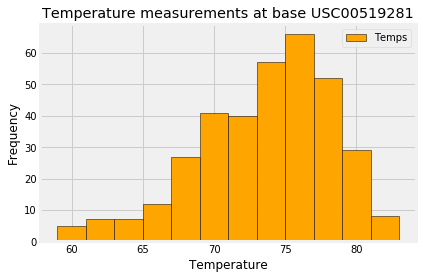

In [14]:
# Histogram plot 
x_vals = tempDF['tobs']

plt.hist(x_vals, bins=12, color='orange',label='Temps', ec='black')
plt.title('Temperature measurements at base {}'.format(busy_base))
plt.xlabel('Temperature')
plt.ylabel('Frequency')

plt.legend()
plt.savefig('Base Temperatures Histogram.png')
plt.show()

In [38]:
# Flask API